# Clusterización / Algoritmo K-means (Core)

**Descripción**
## Algoritmo K-means (Core)
El algoritmo K-means es uno de los métodos de agrupamiento más utilizados en análisis de datos y machine learning. Este algoritmo busca agrupar un conjunto de datos en K grupos o clusters, donde cada grupo está definido por un centroide. En esta actividad, utilizaremos el algoritmo K-means para analizar y segmentar clientes en función de su comportamiento de compra, utilizando el dataset «Mall Customer Segmentation Data» de Kaggle.

Enlace al dataset: https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python

## Objetivo de la Actividad

El objetivo de esta actividad es utilizar el algoritmo K-means para identificar diferentes grupos de clientes según su comportamiento de compra. El análisis de los clusters resultantes permitirá obtener una mejor comprensión de las características de los clientes, lo que puede ser útil para personalizar estrategias de marketing y mejorar la experiencia del cliente.



**Descripción del Algoritmo K-means**

K-means es un algoritmo de aprendizaje no supervisado que agrupa datos en K clusters o grupos, donde K es un número predefinido. Cada cluster se representa mediante un centroide, que es el promedio de todos los puntos de datos en ese grupo. El algoritmo tiene dos fases principales:

1. Asignación de clusters: Cada punto de datos se asigna al centroide más cercano.
2. Actualización de centroides: Se recalcula la posición de los centroides basándose en la media de los puntos de datos asignados a cada cluster.

Este proceso se repite hasta que los centroides no cambian significativamente o se alcanza un número máximo de iteraciones.



In [9]:
# Agregar la carpeta 'src' al sys.path
import sys
import os

# Buscar 'src' automáticamente sin depender del nombre del proyecto
current_dir = os.getcwd()  # Directorio actual
while not os.path.exists(os.path.join(current_dir, "src")):
    current_dir = os.path.dirname(current_dir)  # Subir un nivel
    if current_dir == "/":  # Evitar bucles infinitos
        raise FileNotFoundError("No se encontró la carpeta 'src'. Verifica la estructura.")

src_path = os.path.join(current_dir, "src")
if src_path not in sys.path:
    sys.path.append(src_path)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve,auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.datasets import load_digits
from sklearn.datasets import load_iris

from utils import cargar_datos_pd
from utils import dimensiones
from utils import ver_resumen_nulos
from utils import identificar_atipicos_IQR
from utils import ver_diccionario
from utils import imprimir_bigotes
from utils import plot_varianza
from utils import filtrar_columnas
from utils import desc
from utils import imprimir_bigotes_por_grupo
from utils import generar_diccionario
from utils import obtener_filas_no_numericas
from sklearn.metrics import silhouette_score

## Instrucciones

## 1. Carga del Dataset:
  - El dataset contiene información sobre clientes de un centro comercial, como su género, edad, ingresos anuales y puntaje de gasto.
  - Utiliza el archivo «Mall_Customers.csv» y cárgalo en tu entorno de trabajo.

In [ ]:
# Mall_Customers.csv renombrado a train.csv
diccionario = '../../data/kaggle/core05/diccionario.csv'
ruta_archivo='../../data/kaggle/core05/train.csv'

df = cargar_datos_pd(ruta_archivo,sep=',', header=0)

Dataset cargado con éxito.


In [4]:
ver_diccionario(diccionario)

╒═════╤════════════════════════╤════════╤═════════════════════════════════════════════════════════════════════════╤═══════════╕
│   # │ Columna                │ Tipo   │ Descripción                                                             │ Ejemplo   │
╞═════╪════════════════════════╪════════╪═════════════════════════════════════════════════════════════════════════╪═══════════╡
│   1 │ CustomerID             │ Entero │ Identificador único del cliente                                         │ 1         │
├─────┼────────────────────────┼────────┼─────────────────────────────────────────────────────────────────────────┼───────────┤
│   2 │ Gender                 │ Cadena │ Género del cliente                                                      │ Male      │
├─────┼────────────────────────┼────────┼─────────────────────────────────────────────────────────────────────────┼───────────┤
│   3 │ Age                    │ Entero │ Edad del cliente en años                                      

In [3]:
ver_resumen_nulos(df)

,datos sin NAs en q,Na en q,Na en %
CustomerID,200,0,0.0
Gender,200,0,0.0
Age,200,0,0.0
Annual Income (k$),200,0,0.0
Spending Score (1-100),200,0,0.0


No hay nulos

## 2. Selección de Variables:
  - Para este análisis, selecciona las variables ‘Annual Income (k$)’ y ‘Spending Score (1-100)’, ya que representan características importantes relacionadas con el comportamiento de compra.

## 3. Implementación de K-means:
  - Aplica el algoritmo K-means utilizando diferentes valores de K (por ejemplo, K = 3, 4, 5) y observa cómo se agrupan los clientes.
  - Visualiza los resultados utilizando gráficos de dispersión que representen los clusters y los centroides.

### Según chatgpt

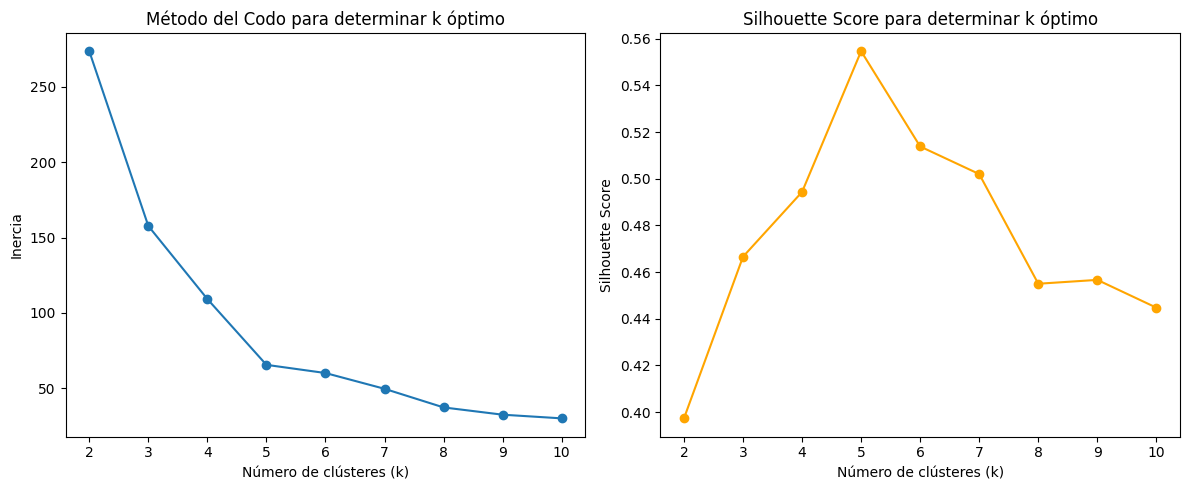

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   Cluster  
0        4  
1        2  
2        4  
3        2  
4        4  


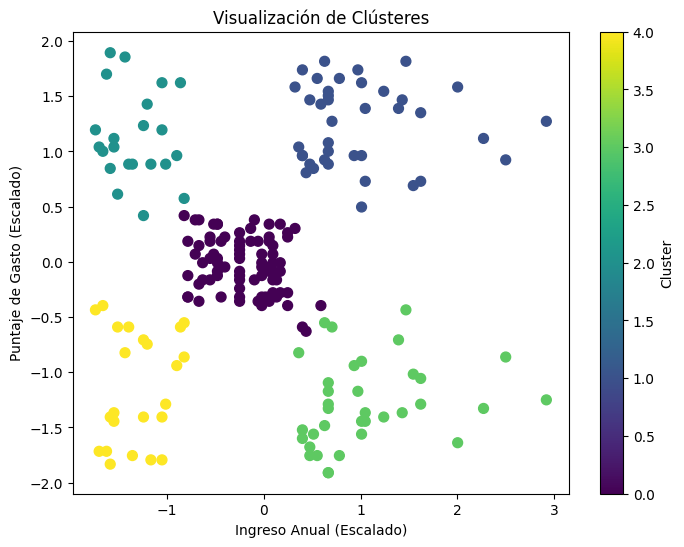

In [19]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Seleccionar las columnas numéricas para el análisis
columnas_para_kmeans = ['Annual Income (k$)', 'Spending Score (1-100)']
datos = df[columnas_para_kmeans]

# Escalamiento de las variables
scaler = StandardScaler()
datos_escalados = scaler.fit_transform(datos)

# Encontrar el número óptimo de clústeres usando el método del codo
inertia = []
silhouette_scores = []
k_range = range(2, 11)  # Probamos para 2 a 10 clústeres (Silhouette requiere al menos 2 clústeres)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(datos_escalados)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(datos_escalados, kmeans.labels_))

# Graficar el método del codo
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Método del Codo para determinar k óptimo')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Inercia')

# Graficar el Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score para determinar k óptimo')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Aplicar K-means con el número de clústeres óptimo (por ejemplo, k=5)
k_optimo = 5
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df['Cluster'] = kmeans.fit_predict(datos_escalados)

# Ver los primeros registros con el clúster asignado
print(df.head())

# Visualizar los clústeres en 2D (usando dos de las variables numéricas)
plt.figure(figsize=(8, 6))
plt.scatter(datos_escalados[:, 0], datos_escalados[:, 1], c=df['Cluster'], cmap='viridis', s=50)
plt.title('Visualización de Clústeres')
plt.xlabel('Ingreso Anual (Escalado)')
plt.ylabel('Puntaje de Gasto (Escalado)')
plt.colorbar(label='Cluster')
plt.show()


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                            K SELECCIONADO:                                                                                             
                                                                                                   3                                                                                                    
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


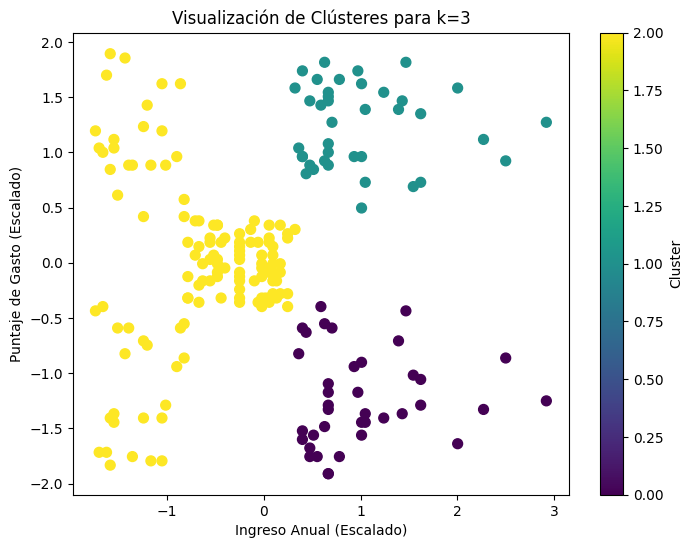

------------------------------------------------------------------------------------------
K SELECCIONADO 3 --> Métrica de Silhouette: 0.47
------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                            K SELECCIONADO:                                                                                             
                                                                                                   4                                                                                                    
----------------------------------------------------------------------------------------------------------------------------------------------------------------------

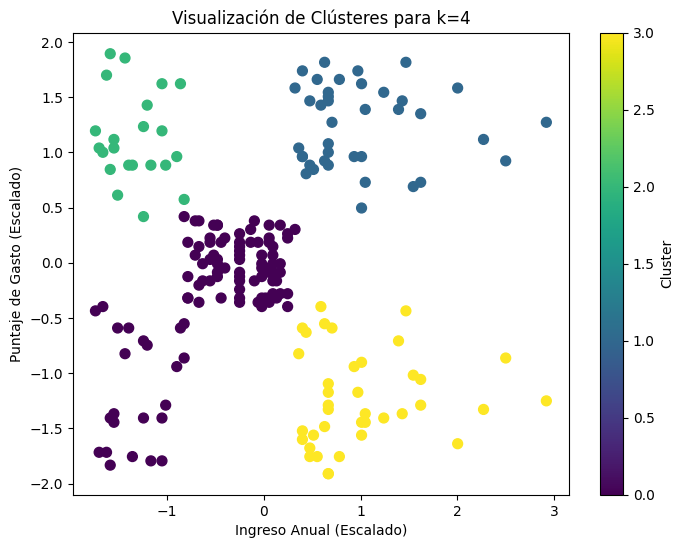

------------------------------------------------------------------------------------------
K SELECCIONADO 4 --> Métrica de Silhouette: 0.49
------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                            K SELECCIONADO:                                                                                             
                                                                                                   5                                                                                                    
----------------------------------------------------------------------------------------------------------------------------------------------------------------------

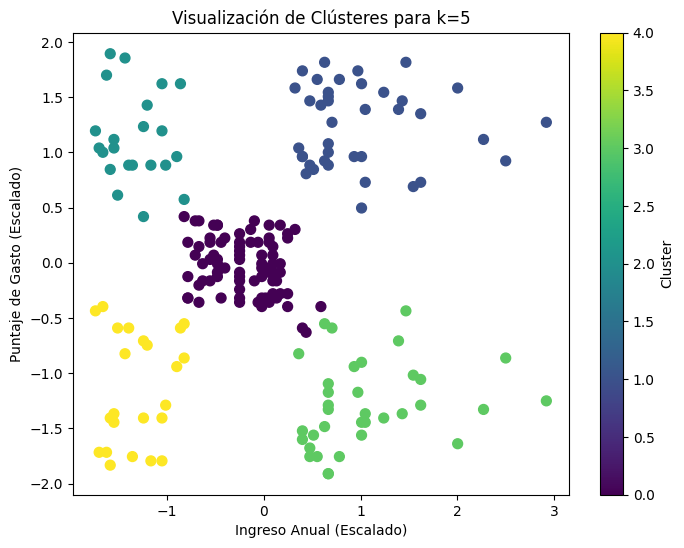

------------------------------------------------------------------------------------------
K SELECCIONADO 5 --> Métrica de Silhouette: 0.55
------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                  FIN                                                                                                   
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [33]:
# Iterar para diferentes valores de k
for k_optimo in range(3, 6):
    print("-" * 200)
    print(f"{'K SELECCIONADO:':^200}")
    print(f"{k_optimo:^200}")
    print("-" * 200)
    
    # Aplicar K-means con el valor actual de k_optimo
    kmeans = KMeans(n_clusters=k_optimo, random_state=42)
    df['Cluster'] = kmeans.fit_predict(datos_escalados)

    # Calcular la métrica de Silhouette
    silhouette_avg = silhouette_score(datos_escalados, df['Cluster'])
    
    # Visualizar los clústeres en 2D
    plt.figure(figsize=(8, 6))
    plt.scatter(datos_escalados[:, 0], datos_escalados[:, 1], c=df['Cluster'], cmap='viridis', s=50)
    plt.title(f'Visualización de Clústeres para k={k_optimo}')
    plt.xlabel('Ingreso Anual (Escalado)')
    plt.ylabel('Puntaje de Gasto (Escalado)')
    plt.colorbar(label='Cluster')
    #plt.figtext(0.15, 0.02, f'Métrica de Silhouette: {silhouette_avg:.2f}', horizontalalignment='left', fontsize=12)
    plt.show()
    print("-" * 90)
    print(f'K SELECCIONADO {k_optimo} --> Métrica de Silhouette: {silhouette_avg:.2f}')
    print("-" * 90)

# Hito final
print("-" * 200)
print(f"{'FIN':^200}")
print("-" * 200)

### Según el código del profe

In [6]:
# Seleccionar columnas relevantes para clustering
columnas_para_kmeans = ['Annual Income (k$)', 'Spending Score (1-100)']

# Extraer las columnas como datos numéricos para clustering
X = df[columnas_para_kmeans].values

# Imprimir la forma de los datos generados
print(f"Dimensiones de X: {X.shape}")


Dimensiones de X: (200, 2)


C:\Users\edgar\AppData\Local\Temp\ipykernel_17264\2338069034.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], s=30, cmap='viridis')


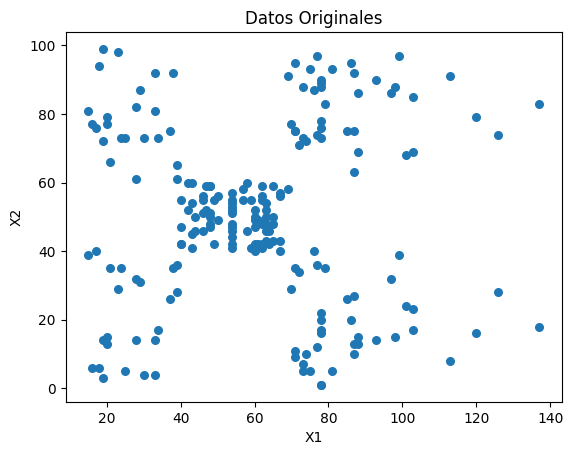

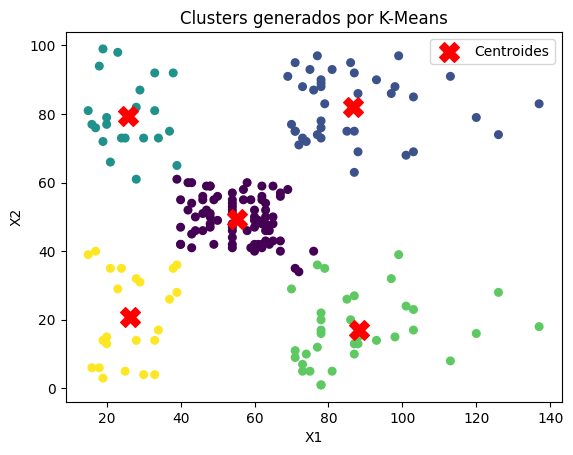

Silhouette Score: 0.55


In [17]:

# Visualizar los datos originales
plt.scatter(X[:, 0], X[:, 1], s=30, cmap='viridis')
plt.title("Datos Originales")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

# Aplicar K-Means pero con 5 según chatgpt
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)

# Predecir etiquetas
y_kmeans = kmeans.predict(X)

# Visualizar los clusters generados por K-Means
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=30, cmap='viridis')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.title("Clusters generados por K-Means")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

# Calcular métrica de Silhouette
silhouette_avg = silhouette_score(X, y_kmeans)
print(f"Silhouette Score: {silhouette_avg:.2f}")

In [ ]:
# Visualizar los clusters generados por K-Means
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=30, cmap='viridis')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroides')

In [22]:
centroids

array([[55.2962963 , 49.51851852],
       [86.53846154, 82.12820513],
       [25.72727273, 79.36363636],
       [88.2       , 17.11428571],
       [26.30434783, 20.91304348]])

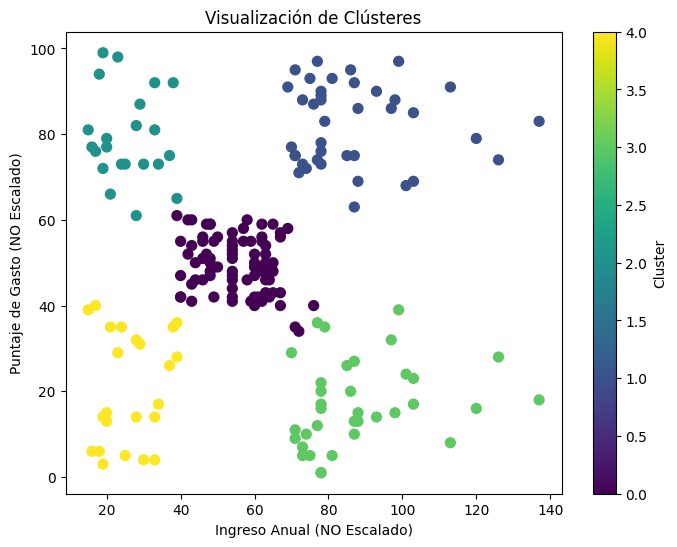

In [24]:
# Visualizar los clústeres en 2D (usando dos de las variables numéricas)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis', s=50)
#centroids = kmeans.cluster_centers_
#plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.title('Visualización de Clústeres')
plt.xlabel('Ingreso Anual (NO Escalado)')
plt.ylabel('Puntaje de Gasto (NO Escalado)')
plt.colorbar(label='Cluster')
plt.show()

## 4. Elbow Method:
  - Utiliza el método del codo para identificar el número óptimo de clusters. Este método consiste en ejecutar K-means con diferentes valores de K y calcular la suma de errores cuadráticos (SSE). El valor óptimo de K se encuentra donde se produce una disminución significativa en el SSE.

Ya lo hicimos más arriba pero lo hacemos de nuevo ...

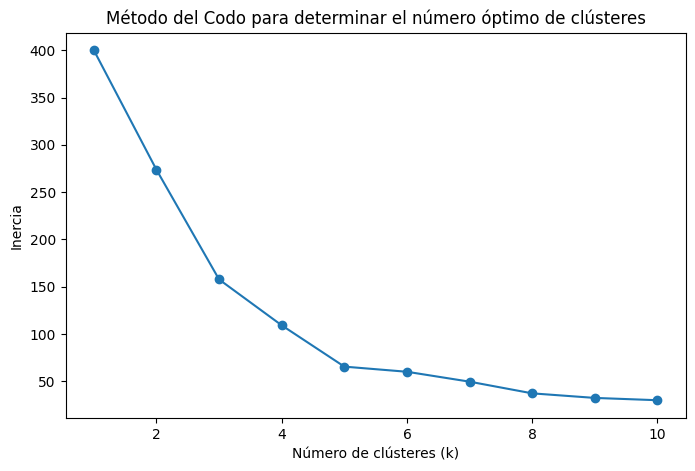

In [34]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Seleccionar las columnas numéricas para el análisis
columnas_para_kmeans = ['Annual Income (k$)', 'Spending Score (1-100)']
datos = df[columnas_para_kmeans]

# Escalamiento de las variables
scaler = StandardScaler()
datos_escalados = scaler.fit_transform(datos)

# Encontrar el número óptimo de clústeres usando el método del codo
inertia = []
k_range = range(1, 11)  # Probamos para 1 a 10 clústeres
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(datos_escalados)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Método del Codo para determinar el número óptimo de clústeres')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Inercia')
plt.show()


## 5. Interpretación de Clusters:
  - Una vez obtenidos los clusters, analiza cada grupo. ¿Qué características tienen en común los clientes de cada cluster? ¿Cómo podrías usar esta información para diseñar estrategias de marketing personalizadas?

### Paso 1: Analizar las características de cada clúster
Para cada clúster generado por K-means, analiza las características de los clientes dentro de cada grupo. Por ejemplo, en un dataset de segmentación de clientes con variables como Ingreso Anual y Puntuación de Gastos, puedes calcular las medias, medianas y otras estadísticas descriptivas para estas variables dentro de cada clúster.

In [45]:
# Aplicar K-means y asignar los clústeres al DataFrame
k_optimo = 5
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
datos['Cluster'] = kmeans.fit_predict(datos_escalados)

# Calcular las medias por clúster
cluster_summary = datos.groupby('Cluster').mean()

# Mostrar el resumen por clúster
print(cluster_summary)


         Annual Income (k$)  Spending Score (1-100)
Cluster                                            
0                 55.296296               49.518519
1                 86.538462               82.128205
2                 25.727273               79.363636
3                 88.200000               17.114286
4                 26.304348               20.913043


C:\Users\edgar\AppData\Local\Temp\ipykernel_17264\3474358068.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos['Cluster'] = kmeans.fit_predict(datos_escalados)


In [47]:
# Analizar las características promedio de cada clúster
datos.groupby('Cluster').mean()


,Annual Income (k$),Spending Score (1-100)
Cluster,,
0,55.296296,49.518519
1,86.538462,82.128205
2,25.727273,79.363636
3,88.200000,17.114286
4,26.304348,20.913043


#### Paso 1: Analizar las características de cada clúster

A continuación, se presentan las estadísticas descriptivas de los clústeres generados por el algoritmo K-Means en el dataset de **Ingreso Anual (k$)** y **Puntuación de Gastos (1-100)**:

### Clústeres Generados:
1. **Cluster 0**:
   - **Ingreso Anual (k$)**: 55.3
   - **Puntuación de Gastos (1-100)**: 49.5
   - **Análisis**: Este grupo tiene un ingreso anual moderado y una puntuación de gastos baja, lo que indica clientes con ingresos razonables pero que no gastan mucho.

2. **Cluster 1**:
   - **Ingreso Anual (k$)**: 86.5
   - **Puntuación de Gastos (1-100)**: 82.1
   - **Análisis**: Con altos ingresos y alta puntuación de gastos, este grupo probablemente corresponda a clientes con un mayor poder adquisitivo y que tienden a gastar más.

3. **Cluster 2**:
   - **Ingreso Anual (k$)**: 25.7
   - **Puntuación de Gastos (1-100)**: 79.4
   - **Análisis**: A pesar de tener ingresos bajos, su puntuación de gastos es alta, lo que podría reflejar un comportamiento de compra impulsiva o una priorización del consumo.

4. **Cluster 3**:
   - **Ingreso Anual (k$)**: 88.2
   - **Puntuación de Gastos (1-100)**: 17.1
   - **Análisis**: Este grupo presenta un alto ingreso anual pero una puntuación de gastos baja, lo que sugiere clientes que, aunque tienen altos ingresos, no gastan de manera frecuente o significativa.

5. **Cluster 4**:
   - **Ingreso Anual (k$)**: 26.3
   - **Puntuación de Gastos (1-100)**: 20.9
   - **Análisis**: Los clientes de este grupo tienen bajos ingresos y también una baja puntuación de gastos, lo que indica un comportamiento de consumo muy limitado.

### Conclusión:
- **Cluster 1** es el grupo con mayores ingresos y mayor disposición al gasto, siendo un objetivo clave para estrategias de marketing de productos premium.
- **Cluster 2**, aunque con bajos ingresos, tiene una alta puntuación de gastos, lo que sugiere que podrían beneficiarse de estrategias que fomenten un control de sus compras.
- **Cluster 0** podría representar una clase intermedia, ideal para productos con precios moderados.
- **Cluster 3** y **Cluster 4** tienen menos ingresos y una menor inclinación a gastar, lo que podría llevar a enfocarse en estrategias de ahorro o descuentos para estos grupos.

Este análisis proporciona una base sólida para adaptar las estrategias de marketing según las características y comportamientos de consumo de cada clúster.


#### Paso 2: Identificar las características clave
Además de las estadísticas descriptivas, es útil visualizar las distribuciones de las variables para cada clúster para entender cómo se agrupan. Un gráfico de dispersión o un gráfico de barras podría ayudarte a ver cómo se distribuyen los datos dentro de los clústeres:

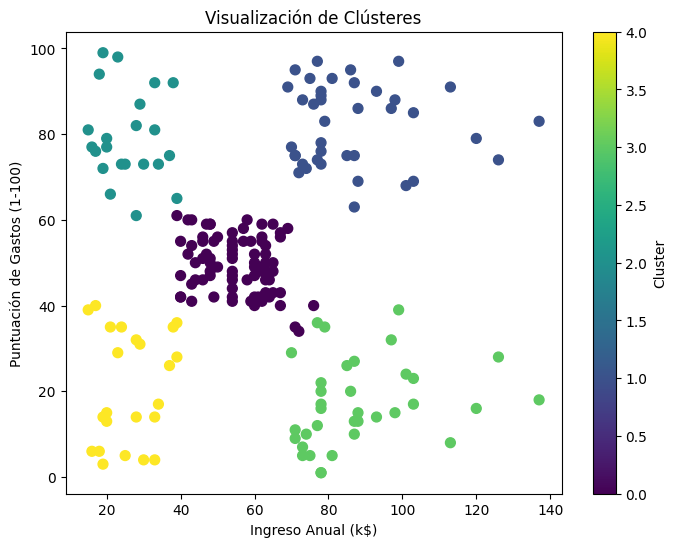

In [48]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], c=df['Cluster'], cmap='viridis', s=50)
plt.title('Visualización de Clústeres')
plt.xlabel('Ingreso Anual (k$)')
plt.ylabel('Puntuación de Gastos (1-100)')
plt.colorbar(label='Cluster')
plt.show()


## 6. Análisis de Resultados:
  - Discute los resultados obtenidos. ¿Qué insights se pueden extraer de los grupos de clientes identificados? ¿Existen patrones o comportamientos comunes?

### Análisis de Resultados: Comportamientos y Patrones en los Clústeres

Al observar los resultados de la segmentación con K-Means, se pueden extraer varios **insights** clave de los grupos de clientes generados. A continuación, se discuten las características y comportamientos comunes de cada clúster identificado:

#### 1. **Cluster 0**:
   - **Características**: Este grupo tiene un ingreso anual moderado (55.3 k$) y una puntuación de gastos baja (49.5).
   - **Insight**: Los clientes en este clúster son consumidores que, aunque cuentan con ingresos razonables, no muestran un alto nivel de gasto. Esto podría indicar que están más enfocados en la racionalización de su consumo o simplemente prefieren productos más asequibles.
   - **Estrategia de marketing**: Las promociones y descuentos moderados pueden ser efectivas para atraer a este grupo.

#### 2. **Cluster 1**:
   - **Características**: Altos ingresos (86.5 k$) y una alta puntuación de gastos (82.1).
   - **Insight**: Este grupo representa a clientes con un poder adquisitivo elevado y un comportamiento de compra frecuente o de lujo. Son un segmento muy valioso para las marcas de productos premium o de lujo, ya que están dispuestos a gastar más en sus compras.
   - **Estrategia de marketing**: Estrategias centradas en productos exclusivos o de alta gama pueden ser eficaces para este grupo.

#### 3. **Cluster 2**:
   - **Características**: Bajos ingresos (25.7 k$) pero alta puntuación de gastos (79.4).
   - **Insight**: Aunque estos clientes tienen un ingreso bajo, tienen un patrón de gasto relativamente alto. Esto podría reflejar comportamientos impulsivos o una prioridad hacia el consumo, incluso a costa de una estabilidad financiera.
   - **Estrategia de marketing**: Ofrecer promociones atractivas o productos de bajo costo pero de alta percepción de valor podría generar lealtad en este segmento.

#### 4. **Cluster 3**:
   - **Características**: Altos ingresos (88.2 k$) pero baja puntuación de gastos (17.1).
   - **Insight**: Estos clientes tienen un alto poder adquisitivo pero no gastan con frecuencia. Esto sugiere que, a pesar de su capacidad financiera, son más cautelosos con sus compras o prefieren ahorrar.
   - **Estrategia de marketing**: Ofrecer productos de inversión o ahorro, así como estrategias que apelen a la racionalidad del consumo, pueden ser más efectivas para este grupo.

#### 5. **Cluster 4**:
   - **Características**: Bajos ingresos (26.3 k$) y baja puntuación de gastos (20.9).
   - **Insight**: Este grupo muestra una baja disposición tanto a gastar como a generar ingresos elevados. Esto podría reflejar clientes que están en una etapa financiera más precaria o que no priorizan el consumo en productos no esenciales.
   - **Estrategia de marketing**: Ofrecer productos muy asequibles o estrategias de ahorro puede ser atractivo para este grupo.

### Patrones Comunes:
- **Clientes de alto ingreso** (Clusters 1 y 3) no siempre están dispuestos a gastar mucho. Esto refleja una tendencia a la cautela o un consumo más racional, lo que podría estar relacionado con un enfoque en productos duraderos o de inversión.
- **Clientes con ingresos bajos pero gastos elevados** (Cluster 2) pueden estar más orientados al consumo inmediato y menos preocupados por las finanzas a largo plazo, lo que podría implicar una mentalidad de compra impulsiva.

### Conclusiones:
- Los **clientes con alto poder adquisitivo** (Cluster 1) y aquellos que combinan **ingresos bajos y gasto alto** (Cluster 2) representan dos extremos de comportamiento que son muy valiosos para diferentes tipos de estrategias de marketing.
- **Clusters 0, 3, y 4** podrían ser más sensibles a promociones y precios competitivos, pero con diferentes enfoques. Cluster 0 tiene un gasto moderado, mientras que los otros dos muestran patrones de consumo más restringidos.

El análisis de estos patrones puede ayudar a diseñar **estrategias de marketing** más personalizadas, basadas en las características y comportamientos de cada segmento de clientes.
